# Visualizing the Covid-19 Pandemic

I've held off on creating a visualization of the pandemic so far because I think things have been [covered well](https://www.ft.com/content/a26fbf7e-48f8-11ea-aeb3-955839e06441) by [others](https://ourworldindata.org/coronavirus). But there are still a few visualizations that I'd like to see, so I decided to give it a try. When I look at a Covid-19 visualization, I generally want to answer a few questions:

* **How bad is it?** Total numbers are needed here to show the human toll.  
* **Is it getting worse?** Time series data is helpful here to put current data in context. Preferably show new cases rather than total cases on the y-axis so we can quickly see increases.    
* **How effective is our response?** Per capita numbers are useful here because they allow us to see how well governments are responding relative to each other.
* **How risky are things for me?** Per capita numbers are also helpful here because they're proportionate to individual risk. But individual risk can also be calculated using a model, which I do below. Either way, the numbers have to be at a small enough resolution (e.g. state or county) to matter for individuals. 

So I created a few visualizations to try to answer these questions. And just to get this out of the way at the start, I want to stress that I am not an epidemiologist (IANAE). But for the most part I'm communicating existing information rather than creating it, so this shouldn't be too much of a problem.

## TODO:
- There is a difference between the reported deaths in the Covid Tracking timeseries and the John's Hopkins timeseries. As of 6/17/2020, there are 117,423 deaths on the JHU tracker vs. 110,695 (6728 difference) on the Covid Tracking website. This especially shows up in the New York state numbers (30,856 vs. 24,608, 6248 difference), which almost entirely accounts for the difference in the numbers.  Maybe look into switching to JHU numbers over time, as this is where the model gets it's death timeseries from.
- New model

In [1]:
import os
from datetime import date, datetime, timedelta
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display, IFrame

#import qgrid

In [2]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [3]:
# Note, this shouldn't be run until mid day, not right when partial data is available.
# Because a mismatch in the data will cause problems. 
def get_data(archive_dir, date_str, sources):
    for label, source in sources.items():
        data = pd.read_csv(source['url'], low_memory=False)
        out_path = os.path.join(archive_dir, source['local'].format(date_str))
        temp_path = os.path.join(archive_dir, source['local'].format('latest'))
        data.to_csv(out_path, index=False)
        data.to_csv(temp_path, index=False)

def load_data(archive_dir, date_str, sources):
    data = {}
    for label, source in sources.items():
        local_path = os.path.join(archive_dir, source['local'].format(date_str))
        data[label] = pd.read_csv(local_path)
        print(label, ': ', source['local'].format(date_str))
    return data

In [4]:
# Could also be an earlier string for retrospective analysis '2020-06-05'
date_str = '2020-11-05' #'2020-06-08' #date.today().isoformat() 
archive_dir = os.path.join(os.getcwd(), 'data', 'archive')


#https://apichanges.covidtracking.com/
#'https://covidtracking.com/api/v1/states/daily.csv'
#https://api.covidtracking.com/v1/states/daily.csv

sources = {
    'world': {
        'url': 'https://covid.ourworldindata.org/data/owid-covid-data.csv',
        'local':'{0}-owid-world.csv',
    },
    'us': {
        'url': 'https://api.covidtracking.com/v1/states/daily.csv',
        'local': '{0}-covidtrackingproject-us.csv'
    },
    'county': {
        'url': 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv',
        'local': '{0}-nytimes-uscounties.csv'
    }
#     'worldmodel': {
#         'url': 'https://raw.githubusercontent.com/youyanggu/covid19_projections/master/projections/combined/latest_global.csv',
#         'local': '{0}-covid19_projections-latest_global.csv'
#     },
#     'statemodel': {
#         'url': 'https://raw.githubusercontent.com/youyanggu/covid19_projections/master/projections/combined/latest_us.csv',
#         'local': '{0}-covid19_projections-latest_us.csv'
#     },
#     'countymodel': {
#         'url': 'https://raw.githubusercontent.com/youyanggu/covid19_projections/master/projections/combined/latest_subregion.csv',
#         'local': '{0}-covid19_projections-latest_subregion.csv'
#     } 
}

get_data(archive_dir, date_str, sources)  #Optional, comment out if using existing data
data = load_data(archive_dir, date_str, sources)

world :  2020-11-05-owid-world.csv
us :  2020-11-05-covidtrackingproject-us.csv
county :  2020-11-05-nytimes-uscounties.csv


# Populations

In [5]:
worldpop_df = pd.read_csv(os.path.join(os.getcwd(), 'data', 'worldpop', 'worldpop.csv'))
worldpop_df = worldpop_df[['Country Name', 'Country Code', '2019']]
worldpop_df.rename(columns={'Country Name': 'location', 'Country Code':'abbr', '2019':'population'},
        inplace=True)
replaces = {'Korea, Rep.':'South Korea', 'Czech Republic': 'Czechia', 
    'Egypt, Arab Rep.': 'Egypt', 'Iran, Islamic Rep.': 'Iran',
    'Russian Federation': 'Russia', 'Slovak Republic': 'Slovakia'}
worldpop_df.replace(to_replace=replaces, inplace=True)
worldpop_df 

,location,abbr,population
0,Aruba,ABW,106314.0
1,Afghanistan,AFG,38041754.0
2,Angola,AGO,31825295.0
3,Albania,ALB,2854191.0
4,Andorra,AND,77142.0
...,...,...,...
259,Kosovo,XKX,1794248.0
260,"Yemen, Rep.",YEM,29161922.0
261,South Africa,ZAF,58558270.0
262,Zambia,ZMB,17861030.0


In [6]:
# https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html
statepop_df = pd.read_csv(os.path.join(os.getcwd(), 'data','state_population.csv'))
statepop_df.head(5)

,state_abbr,state,population
0,AL,Alabama,4903185
1,AK,Alaska,731545
2,AZ,Arizona,7278717
3,AR,Arkansas,3017804
4,CA,California,39512223


In [7]:
# https://stackoverflow.com/questions/19699367
countypop_df = pd.read_csv(os.path.join(os.getcwd(), 'data', 'co-est2019-alldata.csv'), 
    encoding = "ISO-8859-1", dtype={'STATE':'str', 'COUNTY':'str'})
countypop_df['STATE'] = countypop_df['STATE'].str.zfill(2)
countypop_df['COUNTY'] = countypop_df['COUNTY'].str.zfill(3)
countypop_df['fips'] = countypop_df['STATE'] + countypop_df['COUNTY']
countypop_df = countypop_df[['fips', 'STNAME', 'CTYNAME', 'POPESTIMATE2019']]
countypop_df.rename(columns={'STNAME': 'state', 'CTYNAME': 'county', 
    'POPESTIMATE2019':'population'}, inplace=True)
countypop_df = countypop_df.merge(statepop_df[['state_abbr', 'state']], on='state')
#Remove state populations from countypop_df
countypop_df = countypop_df[~(countypop_df['state'] == countypop_df['county'])]
# https://en.wikipedia.org/wiki/List_of_counties_in_New_York
# Five of New York's counties are each coextensive with New York City's five boroughs and 
# do not have county governments. They are New York County (Manhattan), Kings County (Brooklyn),
# Bronx County (The Bronx), Richmond County (Staten Island), and Queens County (Queens). 
nyc_df = countypop_df[countypop_df['county'].isin(['New York County', 'Kings County',
    'Bronx County', 'Richmond County', 'Queens County'])]
nyc_df = pd.DataFrame({'state': ['New York'], 'county': ['New York City County'],
    'population': [nyc_df['population'].sum()], 'state_abbr': ['NY']})
countypop_df = pd.concat([countypop_df, nyc_df])
# Make fake fips for nyc
countypop_df.loc[countypop_df['county'] == 'New York City County', 'fips'] = '0'
countypop_df = countypop_df.sort_values(by='population', ascending=False)
countypop_df.reset_index(inplace=True, drop=True)
display(countypop_df)
# q = qgrid.show_grid(countypop_df)
# q

,fips,state,county,population,state_abbr
0,06037,California,Los Angeles County,10039107,CA
1,0,New York,New York City County,8746127,NY
2,17031,Illinois,Cook County,5150233,IL
3,48201,Texas,Harris County,4713325,TX
4,04013,Arizona,Maricopa County,4485414,AZ
...,...,...,...,...,...
3137,31005,Nebraska,Arthur County,463,NE
3138,48261,Texas,Kenedy County,404,TX
3139,48269,Texas,King County,272,TX
3140,48301,Texas,Loving County,169,TX


# Population Adjusted Timeseries

In [8]:
world_df = data['world'].copy()
world_df = world_df[~world_df['location'].isin(['International', 'World'])]
world_df['date'] = pd.to_datetime(world_df['date'])
cols = ['iso_code', 'location', 'date', 'total_cases','total_deaths_per_million',
    'total_deaths', 'total_cases_per_million', 'new_deaths', 'new_cases', 'new_cases_per_million']
world_df = world_df[cols]
# 7 Day rolling average:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#groupby-transform-window-resample
# Ok, for modeling purposes 3d might be right, but for visualization purposes, 7d is right.
# But even for modeling, 7d might be better, because many country timeseries are showing weekly variation
# in when they report cases using a 3 day smoothing.
world_df = world_df.groupby(by=['iso_code', 'location']) \
    .rolling(window='7d', on='date') \
    .agg({'total_cases': 'max', 'total_cases_per_million': 'max', 'total_deaths': 'max',
        'total_deaths_per_million': 'max', 'new_deaths':'mean', 'new_cases': 'mean', 'new_cases_per_million': 'mean'})

#Clip for log visualization purposes
world_df['new_cases_per_million'] = world_df.new_cases_per_million.clip(lower=0.5) #0.1  0.125
world_df = world_df.reset_index(drop=False)
world_df.rename(columns={'iso_code': 'abbr'}, inplace=True)
world_df = world_df.merge(worldpop_df[['abbr', 'population']] , on='abbr')
display(world_df)

,abbr,location,date,total_cases,total_cases_per_million,total_deaths,total_deaths_per_million,new_deaths,new_cases,new_cases_per_million,population
0,ABW,Aruba,2020-03-13,2.0,18.733,NaN,NaN,0.000000,2.000000,18.733000,106314.0
1,ABW,Aruba,2020-03-19,2.0,18.733,NaN,NaN,0.000000,2.000000,18.733000,106314.0
2,ABW,Aruba,2020-03-20,4.0,37.465,NaN,NaN,0.000000,2.000000,18.733000,106314.0
3,ABW,Aruba,2020-03-21,4.0,37.465,NaN,NaN,0.000000,2.000000,18.733000,106314.0
4,ABW,Aruba,2020-03-22,4.0,37.465,NaN,NaN,0.000000,2.000000,18.733000,106314.0
...,...,...,...,...,...,...,...,...,...,...,...
51841,ZWE,Zimbabwe,2020-11-01,8362.0,562.608,242.0,16.282,0.857143,13.285714,0.893857,14645468.0
51842,ZWE,Zimbabwe,2020-11-02,8374.0,563.415,243.0,16.349,0.857143,14.000000,0.941857,14645468.0
51843,ZWE,Zimbabwe,2020-11-03,8389.0,564.424,245.0,16.484,0.428571,12.285714,0.826429,14645468.0
51844,ZWE,Zimbabwe,2020-11-04,8410.0,565.837,246.0,16.551,0.571429,13.571429,0.913000,14645468.0


In [9]:
us_df = data['us'].copy()
# Note: 'positive' is the total positive count, positiveIncrease is that day's increase in cases.
cols = ['date', 'state', 'positive', 'positiveIncrease', 'death', 'deathIncrease']
us_df = us_df[cols]
us_df = us_df[~us_df[['positive', 'positiveIncrease', 'death', 'deathIncrease']].isnull().any(1)]
us_df['date'] = pd.to_datetime(us_df['date'], format='%Y%m%d')
us_df.rename(columns={'state': 'state_abbr', 'positive': 'total_cases',
    'positiveIncrease':'new_cases', 'deathIncrease': 'new_deaths',
    'death': 'total_deaths'}, inplace=True)
us_df = us_df.merge(statepop_df, on='state_abbr')
us_df['total_cases_per_million'] = (us_df['total_cases']/us_df['population'])*1000000
us_df['new_cases_per_million'] = (us_df['new_cases']/us_df['population'])*1000000
us_df['total_deaths_per_million'] = (us_df['total_deaths']/us_df['population'])*1000000
us_df = us_df[['date', 'state_abbr','state', 'population', 'total_cases', 'new_cases',
    'total_cases_per_million', 'new_cases_per_million', 'new_deaths', 'total_deaths', 
    'total_deaths_per_million']]
us_df.rename(columns={'state_abbr':'iso_code', 'state':'location'}, inplace=True)
us_df = us_df.sort_values(by='date', ascending=True)

# Smooth with rolling average
# https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#groupby-transform-window-resample
us_df = us_df.groupby(by=['iso_code', 'location']) \
    .rolling(window='7d', on='date') \
    .agg({'population':'max', 'total_cases': 'max', 'total_cases_per_million': 'max', 'total_deaths': 'max',
        'total_deaths_per_million': 'max','new_deaths': 'mean', 
        'new_cases': 'mean', 'new_cases_per_million': 'mean'})
#Clip after aggregation, for log plot purposes
us_df['new_cases_per_million'] = us_df['new_cases_per_million'].clip(lower=0.125) #0.1
us_df.reset_index(drop=False, inplace=True)
us_df = us_df.rename(columns={'iso_code': 'abbr'})
display(us_df)

,abbr,location,date,population,total_cases,total_cases_per_million,total_deaths,total_deaths_per_million,new_deaths,new_cases,new_cases_per_million
0,AK,Alaska,2020-03-06,731545.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.125000
1,AK,Alaska,2020-03-07,731545.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.125000
2,AK,Alaska,2020-03-08,731545.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.125000
3,AK,Alaska,2020-03-09,731545.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.125000
4,AK,Alaska,2020-03-10,731545.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.125000
...,...,...,...,...,...,...,...,...,...,...,...
11920,WY,Wyoming,2020-11-01,578759.0,13723.0,23711.078359,87.0,150.321636,2.714286,383.142857,662.007601
11921,WY,Wyoming,2020-11-02,578759.0,14167.0,24478.237055,87.0,150.321636,1.428571,384.285714,663.982269
11922,WY,Wyoming,2020-11-03,578759.0,14619.0,25259.218431,93.0,160.688646,2.285714,401.857143,694.342797
11923,WY,Wyoming,2020-11-04,578759.0,15044.0,25993.548264,105.0,181.422665,4.000000,414.000000,715.323649


In [10]:
#topcounties_df = countypop_df.sort_values(by='population', ascending=False) #.head(100)
county_df = data['county'].copy()
county_df['date'] = pd.to_datetime(county_df['date'])
county_df['fips'] = county_df['fips'].astype('Int64').astype('str')
county_df['fips'] = county_df['fips'].str.zfill(5)
# Make fake fips for nyc
county_df.loc[county_df['county'] == 'New York City', 'fips'] = '0'
county_df.rename(columns={'county':'abbr'}, inplace=True)
county_df = county_df[['date', 'state','abbr','fips', 'cases', 'deaths']] \
    .merge(countypop_df[['fips', 'county', 'state_abbr', 'population']], on='fips', how='inner')
# county_df[['fips']].drop_duplicates() #only 422, not sure why some missing, after join
# https://stackoverflow.com/questions/48347497/pandas-groupby-diff
county_df[['new_cases', 'new_deaths']] = county_df.sort_values(by='date', ascending=True) \
    .groupby(by=['fips', 'county', 'state', 'state_abbr']) \
    [['cases', 'deaths']].diff().fillna(0)
per_mil = ['new_cases_per_million', 'new_deaths_per_million', 'total_cases_per_million', 'total_deaths_per_million']
nominators = ['new_cases', 'new_deaths', 'cases', 'deaths']
for i, el in enumerate(per_mil):
    county_df[el] = (county_df[nominators[i]] / county_df['population'])*1000000

county_df['location'] = county_df['county'] + ', ' + county_df['state_abbr']
county_df.rename(columns={'cases': 'total_cases', 'deaths': 'total_deaths'}, inplace=True)

# Smooth with rolling average
# https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#groupby-transform-window-resample
county_df = county_df.groupby(by=['location', 'abbr', 'fips']) \
    .rolling(window='7d', on='date') \
    .agg({'population': 'max', 'total_cases': 'max', 'total_cases_per_million': 'max', 'total_deaths': 'max',
        'total_deaths_per_million': 'max','new_deaths': 'mean', 
        'new_cases': 'mean', 'new_cases_per_million': 'mean'})
county_df.reset_index(drop=False, inplace=True)



#Pull out the top 100 for visualization
topcounties_df = countypop_df.sort_values(by='population', ascending=False).head(75) #100
countyvis_df = county_df[county_df['fips'].isin(topcounties_df['fips'])].copy()
#Clip after aggregation, for log plot purposes
countyvis_df['new_cases_per_million'] = countyvis_df['new_cases_per_million'].clip(lower=8)

#Pull out the top 250 for table
othertopcounties_df = countypop_df.sort_values(by='population', ascending=False).head(250) #500 200
county_df = county_df[county_df['fips'].isin(othertopcounties_df['fips'])]

display(county_df)
#q = qgrid.show_grid(county_df)
#q

,location,abbr,fips,date,population,total_cases,total_cases_per_million,total_deaths,total_deaths_per_million,new_deaths,new_cases,new_cases_per_million
689,"Ada County, ID",Ada,16001,2020-03-13,481587.0,1.0,2.076468,0.0,0.000000,0.000000,0.000000,0.000000
690,"Ada County, ID",Ada,16001,2020-03-14,481587.0,2.0,4.152936,0.0,0.000000,0.000000,0.500000,1.038234
691,"Ada County, ID",Ada,16001,2020-03-15,481587.0,2.0,4.152936,0.0,0.000000,0.000000,0.333333,0.692156
692,"Ada County, ID",Ada,16001,2020-03-16,481587.0,2.0,4.152936,0.0,0.000000,0.000000,0.250000,0.519117
693,"Ada County, ID",Ada,16001,2020-03-17,481587.0,3.0,6.229404,0.0,0.000000,0.000000,0.400000,0.830587
...,...,...,...,...,...,...,...,...,...,...,...,...
675995,"York County, SC",York,45091,2020-10-31,280979.0,6896.0,24542.759423,107.0,380.811377,0.714286,56.000000,199.303151
675996,"York County, SC",York,45091,2020-11-01,280979.0,7000.0,24912.893846,107.0,380.811377,0.714286,61.571429,219.131781
675997,"York County, SC",York,45091,2020-11-02,280979.0,7046.0,25076.607149,107.0,380.811377,0.571429,62.000000,220.657060
675998,"York County, SC",York,45091,2020-11-03,280979.0,7153.0,25457.418526,107.0,380.811377,0.571429,68.857143,245.061527


In [11]:
def timeseries_chart(df, y, line_quantile, tooltip, title, width, height, detail=None, base=2):
    since_df = df.copy()
    since_df = since_df[since_df['total_cases'] > 100] #total_cases_per_million > 1, total_cases > 100 ['new_cases_per_million'] > 1

    min_df = since_df.groupby(by=['location']).agg({'date':'min'})
    min_df.rename(columns={'date':'min_date'}, inplace=True)
    # Merge back on, using right outer join to eliminate countries not past 100 cases yet
    since_df = since_df.merge(min_df, on='location', how='right')
    since_df['days_since'] = since_df.date - since_df.min_date
    since_df['days_since'] = since_df['days_since'].apply(lambda x: x.days)
 
    lines_df = since_df.copy()
    # https://stackoverflow.com/a/54041328
    points_df = lines_df.sort_values(by='days_since', ascending=True) \
        .groupby(['location', 'abbr']) \
        .tail(1)
    top = lines_df.groupby(by=['location']).agg({'total_cases':'max'})
    top.reset_index(drop=False, inplace=True)
    top = top[top.total_cases >= top.total_cases.quantile(line_quantile)]['location']
    lines_df = lines_df[lines_df['location'].isin(top)]
    

    lines_df = lines_df[['days_since', 'location', 'new_cases_per_million']]
    
    #https://stackoverflow.com/questions/25055712
    #df.iloc[::5, :]
    #TODO: find a way to resample this so rendering lines isn't so intensive
    lines_df = lines_df.sort_values(by='days_since', ascending=True)
    oldest = lines_df.groupby(by='location').head(1)
    most_recent = lines_df.groupby(by='location').tail(1)
    lines_df = lines_df.iloc[::3, :]
    lines_df = pd.concat([lines_df, oldest, most_recent])

    #scale=alt.Scale()
    #x_domain = [points_df['total_cases_per_million'].min(), points_df['total_cases_per_million'].max()]
    #y_domain = [points_df['new_cases_per_million'].min(), points_df['new_cases_per_million'].max()]
    y_domain = [points_df[y].min(), points_df[y].max()]
    #y_domain = [lines_df[y].min(), lines_df[y].max()]
    #y_scale=alt.Scale(domain=y_domain)
    y_scale=alt.Scale(type='log', domain=y_domain, base=base) #10 2
    y_axis=alt.Y('{0}:Q'.format(y), scale=y_scale, title='New cases per million')
    #x_domain = [max([0, points_df['days_since'].min()-5]), points_df['days_since'].max()]
    #x_scale=alt.Scale()
    x_axis=alt.X('days_since:Q', title='Days since 100 cases') #scale=x_scale
    #y=alt.Y('new_cases:Q', scale=scale) #scale=alt.Scale(type='log')

    # https://altair-viz.github.io/gallery/multiline_highlight.html
    highlight = alt.selection(type='single', on='mouseover', fields=['location']) #, nearest=True

    timeseries_lines = alt.Chart(lines_df).mark_line(
        interpolate='basis',
        color='gray'
    ).encode(
        x=x_axis,
        y=y_axis,
        order='days_since:Q',
        detail='location:N',
        opacity=alt.condition(~highlight, alt.value(0.2), alt.value(1.0))
    )
    
    dot_str = 'total_deaths:Q' # total_deaths:Q total_cases:Q
    
    # https://stackoverflow.com/questions/57560694/how-do-i-set-label-text-size-in-altair
    text = alt.Chart(points_df).mark_text(
        align='center',
        baseline='middle',
        size=9
    ).encode(
        x=x_axis,
        y=y_axis,
        text='abbr:N'
    )
    
    if detail: 
        timeseries_points = alt.Chart(points_df).mark_point().encode(
            x=x_axis,
            y=y_axis,
            size=alt.Size(dot_str, scale=alt.Scale(range=[50,4000]), legend=alt.Legend(clipHeight=15)),
            color=alt.Color(dot_str, scale=alt.Scale(scheme='goldred')),
            detail=detail,  #alt.Detail(field=detail), #, legend=alt.Legend()
            fill=alt.Color(dot_str, scale=alt.Scale(scheme='goldred')),
            opacity=alt.condition(~highlight, alt.value(0.75), alt.value(0.9)),
            order=alt.Order(dot_str, sort="descending"),
            tooltip=tooltip
        )
    else:
        timeseries_points = alt.Chart(points_df).mark_point().encode(
            x=x_axis,
            y=y_axis,
            size=alt.Size(dot_str, scale=alt.Scale(range=[50,4000]), legend=alt.Legend(clipHeight=15)),
            color=alt.Color(dot_str, scale=alt.Scale(scheme='goldred')),
            fill=alt.Color(dot_str, scale=alt.Scale(scheme='goldred')),
            opacity=alt.condition(~highlight, alt.value(0.75), alt.value(0.9)),
            order=alt.Order(dot_str, sort="descending"),
            tooltip=tooltip
        )
    
    timeseries_chart = (timeseries_points + text + timeseries_lines).properties(
        title=title,
        width=width,  #700  600  800
        height=height #500  450  600
#         width='container', #https://stackoverflow.com/a/59580645
#         height='container'
    ).interactive().add_selection(highlight)
    
    return timeseries_chart

In [12]:
world_tooltip=[
    alt.Tooltip('location:N'),
    alt.Tooltip('date:T'),
    alt.Tooltip('new_cases:Q', format=',.0f'),
    alt.Tooltip('new_cases_per_million:Q', format=',.1f'),
    alt.Tooltip('total_cases:Q', format=',.0f'),
    alt.Tooltip('total_cases_per_million:Q', format=',.0f'),
    alt.Tooltip('total_deaths:Q', format=',.0f'),
    alt.Tooltip('total_deaths_per_million:Q', format=',.0f')
]
world_timeseries = timeseries_chart(
    world_df, 
    y='new_cases_per_million',
    line_quantile=0.65, tooltip=world_tooltip, #0.65
    title='New Covid-19 cases per million, World, {0}'.format(date_str),
    width=800,
    height=550
)
#world_timeseries.save('world.html')
display(world_timeseries)

alt.LayerChart(...)

In [13]:
us_tooltip=[
    alt.Tooltip('location:N'),
    alt.Tooltip('date:T'),
    alt.Tooltip('new_cases:Q', format=',.0f'),
    alt.Tooltip('new_cases_per_million:Q', format=',.0f'),
    alt.Tooltip('total_cases:Q', format=',.0f'),
    alt.Tooltip('total_cases_per_million:Q', format=',.0f'),
    alt.Tooltip('total_deaths:Q', format=',.0f'),
    alt.Tooltip('total_deaths_per_million:Q', format=',.0f')
]

#us_df[us_df.abbr != 'MA']
us_timeseries = timeseries_chart(
    us_df,
    y='new_cases_per_million',
    line_quantile=0, 
    tooltip=us_tooltip,
    title='New Covid-19 cases per million, US, {0}'.format(date_str),
    width=800,
    height=550
)
display(us_timeseries)

alt.LayerChart(...)

In [14]:
county_tooltip=[
    alt.Tooltip('location:N'),
    alt.Tooltip('date:T'),
    alt.Tooltip('new_cases:Q', format=',.0f'),
    alt.Tooltip('new_cases_per_million:Q', format=',.0f'),
    alt.Tooltip('total_cases:Q', format=',.0f'),
    alt.Tooltip('total_cases_per_million:Q', format=',.0f'),
    alt.Tooltip('total_deaths:Q', format=',.0f'),
    alt.Tooltip('total_deaths_per_million:Q', format=',.0f')
]
county_timeseries = timeseries_chart(
    countyvis_df,
    y='new_cases_per_million',
    line_quantile=0.5, 
    tooltip=county_tooltip,
    title='New Covid-19 cases per million, US Counties, {0}'.format(date_str),
    width=800,
    height=550,
    base=2
)
display(county_timeseries)

alt.LayerChart(...)

In [15]:
worldtable_df = world_df.copy()
worldtable_df['type'] = 'country'
ustable_df = us_df.copy()
ustable_df['type'] = 'usstate'
countytable_df = county_df.copy()
countytable_df['type'] = 'uscounty'
allcase_df = pd.concat([worldtable_df, ustable_df, countytable_df])

case10_df = allcase_df.groupby(by=['abbr', 'location']) \
    .rolling('10d', on='date') \
    .agg({'new_cases':'sum'})
case10_df.rename(columns={'new_cases': 'new_cases_10'}, inplace=True)
case10_df.reset_index(drop=False, inplace=True)
allcase_df = allcase_df.merge(case10_df, on=['abbr', 'location', 'date'])
allcase_df['simple_probability'] = ((allcase_df['new_cases_10']*10/allcase_df['population']))*100

In [16]:
html_template = '''
<!DOCTYPE html>
<html>
<head>
<meta charset="utf-8">
<script type="text/javascript" charset="utf8" src="https://code.jquery.com/jquery-3.5.1.min.js"></script>
<link type="text/css" rel="stylesheet" href="https://cdn.datatables.net/1.10.21/css/jquery.dataTables.min.css">
<script type="text/javascript" charset="utf8" src="https://cdn.datatables.net/1.10.21/js/jquery.dataTables.min.js"></script>
<style>
body {font-family:sans-serif;font-size:12px;}
</style
</head>
<body>

<div>
||table||
</div>

<script>
 $(document).ready( function () {
     $('table[id^=T_]').DataTable(||datatable_def||);
 });
</script>

</body>
</html>
'''

cols=['date', 'location', 'type', 'total_cases', 'total_cases_per_million', 
    'total_deaths', 'total_deaths_per_million', 'new_cases', 'new_cases_per_million', 'simple_probability']
casetable_df = allcase_df[cols].copy()

# Get most recent off top
casetable_df = casetable_df.sort_values(by='date', ascending=False) \
    .groupby(by='location') \
    .head(1)
casetable_df = casetable_df.sort_values(by='simple_probability', ascending=False)
casetable_df.reset_index(drop=True, inplace=True)
casetable_df = casetable_df.round(2)
casetable_df = casetable_df[~casetable_df.isnull().any(1)]

outtable_df = casetable_df.copy()
outtable_df['date'] = outtable_df['date'].apply(lambda x: x.strftime('%Y-%m-%d'))
dtcols = str(list(map(lambda x: {'data': x, 'title': x}, cols)))

datatable_def = '''{
    columnDefs: [
        { 'targets': [1], type: 'date'},
        { 'targets': [4,5,6,7,8,9,10], type:'num'}
    ],
    autoWidth: true,
    paging: false,
    scrollY: 600,
    scrollX: 900,
    order: [[10, 'desc']],
}'''

outtable = outtable_df.style.background_gradient(cmap='Reds') \
    .set_precision(2) \
    .set_table_attributes('class="row-border responsive compact stripe hover" style="width:100%"') \
    .render()
casetable_html = html_template.replace("||table||", outtable)
casetable_html = casetable_html.replace("||datatable_def||", datatable_def)

display(casetable_df.head(50).style.background_gradient(cmap='Reds').set_precision(2))

,date,location,type,total_cases,total_cases_per_million,total_deaths,total_deaths_per_million,new_cases,new_cases_per_million,simple_probability
0,2020-11-04 00:00:00,"El Paso County, TX",uscounty,56355.00,67150.20,669.00,797.15,1847.14,2200.98,16.77
1,2020-11-05 00:00:00,North Dakota,usstate,49837.00,65397.57,468.00,614.12,1243.86,1632.23,13.33
2,2020-11-03 00:00:00,Belgium,country,462944.00,39944.72,12165.00,1049.65,13055.14,1126.45,13.09
3,2020-11-05 00:00:00,Andorra,country,5045.00,65294.76,75.00,970.68,75.43,976.23,12.36
4,2020-11-05 00:00:00,South Dakota,usstate,51151.00,57820.02,482.00,544.84,1164.43,1316.25,12.23
5,2020-11-05 00:00:00,Czech Republic,country,378716.00,35364.33,4133.00,385.94,11671.86,1089.91,11.35
6,2020-11-04 00:00:00,"Lubbock County, TX",uscounty,21319.00,68644.97,230.00,740.58,372.43,1199.18,10.76
7,2020-11-05 00:00:00,Luxembourg,country,20344.00,32499.65,171.00,273.17,669.43,1069.42,9.77
8,2020-11-05 00:00:00,French Polynesia,country,8949.00,31857.86,38.00,135.28,350.86,1249.03,9.44
9,2020-11-05 00:00:00,Slovenia,country,39408.00,18955.89,321.00,154.41,1599.00,769.14,8.27


In [18]:
#Although interesting, too cluttered to be useful? I just wish I could figure out the legend
#highlighting. . .
# all_tooltip=[
#     alt.Tooltip('location:N'),
#     alt.Tooltip('date:T'),
#     alt.Tooltip('new_cases:Q', format=',.0f'),
#     alt.Tooltip('new_cases_per_million:Q', format=',.0f'),
#     alt.Tooltip('total_cases:Q', format=',.0f'),
#     alt.Tooltip('total_cases_per_million:Q', format=',.0f'),
#     alt.Tooltip('total_deaths:Q', format=',.0f'),
#     alt.Tooltip('total_deaths_per_million:Q', format=',.0f')
# ]
# all_timeseries = timeseries_chart(
#     allcase_df,
#     y='new_cases_per_million',
#     line_quantile=0.75, 
#     tooltip=all_tooltip,
#     title='New Covid-19 cases per million, US Counties, {0}'.format(date_str),
#     width=800,
#     height=550,
#     detail='type:N'
# )
# display(all_timeseries)

#display(us_timeseries + county_timeseries)

# What's the probability a person has Covid-19?

In [19]:
# worldmodel_df = data['worldmodel'].copy()
# usmodel_df = data['statemodel'].copy()
# usmodel_df = usmodel_df[
#     (usmodel_df.country == 'US') &
#     (usmodel_df.region.isnull())
# ]
# usmodel_df.replace(to_replace={'US': 'United States'}, inplace=True)
# worldmodel_df = pd.concat([worldmodel_df, usmodel_df])
# worldmodel_df = worldmodel_df[['date', 'country','actual_deaths', 'total_deaths', 
#     'predicted_deaths_mean', 'predicted_total_deaths_mean','predicted_new_infected_mean',
#     'predicted_current_infected_mean', 'predicted_total_infected_mean']]
# worldmodel_df.rename(columns={'country': 'location'}, inplace=True)
# worldmodel_df = worldmodel_df.merge(worldpop_df, on='location', how='left')
# not_matched = worldmodel_df[worldmodel_df.population.isnull()]['location'].drop_duplicates()
# if len(not_matched) > 0:
#     print('Not matched!:')
#     print(not_matched)

# worldmodel_df['probability_infected'] = (worldmodel_df['predicted_current_infected_mean']/
#     worldmodel_df['population'])
# worldmodel_df['predicted_new_infected_per_million'] = (worldmodel_df['predicted_new_infected_mean']/
#     worldmodel_df['population'])*1000000
# worldmodel_df['date'] = pd.to_datetime(worldmodel_df['date'])
# worldmodel_df.rename(columns={'state':'location', 'state_abbr': 'abbr',
#     'predicted_new_infected_mean':'pred_new_infected_mean',
#     'predicted_new_infected_per_million':'pred_new_infected_per_mil',
#     'predicted_total_infected_mean': 'pred_total_infected_mean'}, inplace=True)
# cols = ['date', 'total_deaths', 'location', 'abbr', 'probability_infected',
#     'pred_new_infected_mean', 'pred_new_infected_per_mil', 'pred_total_infected_mean']
# worldmodel_df =  worldmodel_df[cols]
# worldmodel_df = worldmodel_df[worldmodel_df.date < date_str]

# display(worldmodel_df)

In [19]:
# statemodel_df = data['statemodel'].copy()
# statemodel_df = statemodel_df[['date', 'region','actual_deaths', 'total_deaths', 'subregion', 
#     'predicted_deaths_mean', 'predicted_total_deaths_mean','predicted_new_infected_mean',
#     'predicted_current_infected_mean', 'predicted_total_infected_mean']]
# statemodel_df = statemodel_df[~statemodel_df.region.isnull()]
# statemodel_df.rename(columns={'region':'state_abbr'}, inplace=True)
# statemodel_df = statemodel_df.merge(statepop_df, on='state_abbr')
# statemodel_df['probability_infected'] = (statemodel_df['predicted_current_infected_mean']/
#     statemodel_df['population'])
# statemodel_df['predicted_new_infected_per_million'] = (statemodel_df['predicted_new_infected_mean']/
#     statemodel_df['population'])*1000000
# statemodel_df['date'] = pd.to_datetime(statemodel_df['date'])
# statemodel_df.rename(columns={'state':'location', 'state_abbr': 'abbr',
#     'predicted_new_infected_mean':'pred_new_infected_mean',
#     'predicted_new_infected_per_million':'pred_new_infected_per_mil',
#     'predicted_total_infected_mean': 'pred_total_infected_mean'}, inplace=True)

# cols = ['date', 'total_deaths', 'location', 'abbr', 'probability_infected',
#     'pred_new_infected_mean', 'pred_new_infected_per_mil', 'pred_total_infected_mean']
# statemodel_df =  statemodel_df[cols]

# statemodel_df = statemodel_df[statemodel_df.date < date_str]
# display(statemodel_df)

In [20]:
# countymodel_df = data['countymodel'].copy()
# countymodel_df = countymodel_df[countymodel_df['country'] == 'US']

# countymodel_df = countymodel_df[['date', 'country', 'region', 'subregion','actual_deaths', 'total_deaths', 
#     'predicted_deaths_mean', 'predicted_total_deaths_mean','predicted_new_infected_mean',
#     'predicted_current_infected_mean', 'predicted_total_infected_mean']]
# countymodel_df = countymodel_df[~countymodel_df.subregion.isnull()]
# countymodel_df.rename(columns={'region':'state_abbr', 'subregion':'county'}, inplace=True)
# countymodel_df['abbr'] = countymodel_df['county']
# # cq = qgrid.show_grid(countymodel_df)
# # cq
# # This has none of the e.g. "Chesapeake city" counties that are actually
# # independent cities (https://en.wikipedia.org/wiki/Independent_city_(United_States))
# # So just appending ' County' to the end isn't a problem. bit it still is a problem 
# # for the nytimes data by county above. But the actual census source uses ' County' for some names,
# # so it needs to be done here for the join to work. 
# countymodel_df['county'] = countymodel_df['county'] + ' County'
# # This merge is done on county and state abbreviation, so you don't really need the countypop_df
# # to append ' County' at all for this to work.
# countymodel_df = countymodel_df.merge(countypop_df, on=['county', 'state_abbr'], how='left')

# countymodel_df['probability_infected'] = (countymodel_df['predicted_current_infected_mean']/
#     countymodel_df['population'])
# countymodel_df['predicted_new_infected_per_million'] = (countymodel_df['predicted_new_infected_mean']/
#     countymodel_df['population'])*1000000
# countymodel_df['date'] = pd.to_datetime(countymodel_df['date'])
# countymodel_df = countymodel_df[countymodel_df.date < date_str]
# countymodel_df.rename(columns={'county':'location', 
#     'predicted_new_infected_mean':'pred_new_infected_mean',
#     'predicted_new_infected_per_million':'pred_new_infected_per_mil',
#     'predicted_total_infected_mean': 'pred_total_infected_mean'}, inplace=True)
# #Make location a unique identifier
# countymodel_df['location'] = countymodel_df['location'] + ', ' + countymodel_df['state_abbr']

# cols = ['date','state_abbr', 'location','abbr', 'actual_deaths', 'total_deaths', 
#     'probability_infected','pred_new_infected_mean', 'pred_new_infected_per_mil',
#     'pred_total_infected_mean']
# countymodel_df =  countymodel_df[cols]

# display(countymodel_df)

In [21]:
# def model_timeseries_chart(df, y, line_quantile, tooltip, title, base):
#     since_df = df.copy()
#     #total_cases_per_million > 1, total_cases > 100 'new_cases_per_million' > 1
#     since_df = since_df[since_df['pred_total_infected_mean'] > 100]
    
#     #['abbr'], ['abbr', 'state_abbr]
#     min_df = since_df.groupby(by=['location']).agg({'date':'min'})
#     min_df.rename(columns={'date':'min_date'}, inplace=True)
#     # Merge back on, using right outer join to eliminate countries not past 100 cases yet
#     since_df = since_df.merge(min_df, on='location', how='right') #'abbbr'
#     since_df['days_since'] = since_df.date - since_df.min_date
#     since_df['days_since'] = since_df['days_since'].apply(lambda x: x.days)
#     since_df.reset_index(drop=False, inplace=True)
 
#     lines_df = since_df.copy()
#     # https://stackoverflow.com/a/54041328
#     # If model hasn't been updated, this makes sure the last bubble selected has total
#     # deaths, but it leads to the situation where you have infection probabilities
#     # but no total death data for a date. If this happens, just don't publish results.
#     points_df = lines_df.copy()
#     points_df = points_df[~points_df[['total_deaths']].isnull().any(1)]
#     points_df = points_df.sort_values(by='days_since', ascending=True) \
#         .groupby(['location']) \
#         .tail(1)
#     #print(points_df)
#     top = lines_df.groupby(by=['location']).agg({'total_deaths':'max'})
#     top.reset_index(drop=False, inplace=True)
#     top = top[top.total_deaths >= top.total_deaths.quantile(line_quantile)]['location']
#     lines_df = lines_df[lines_df['location'].isin(top)]
#     lines_df = lines_df[['days_since', 'location', 'probability_infected']]
    
#     #https://stackoverflow.com/questions/25055712
#     #df.iloc[::5, :]
#     #TODO: find a way to resample this so rendering lines isn't so intensive
#     lines_df = lines_df.sort_values(by='days_since', ascending=True)
#     oldest = lines_df.groupby(by='location').head(1)
#     most_recent = lines_df.groupby(by='location').tail(1)
#     lines_df = lines_df.iloc[::3, :] # get every 3
#     lines_df = pd.concat([lines_df, oldest, most_recent])

#     #y_domain = [points_df[y].min(), points_df[y].max()]
#     y_domain = [points_df[y].min(), points_df[y].max() + 0.01]
#     #y_domain = [lines_df[y].min(), lines_df[y].max()]
#     #y_scale=alt.Scale(domain=y_domain)
#     y_scale=alt.Scale(type='log', domain=y_domain, base=base) #10
#     # if y_fmt:
#     #     y_axis=alt.Y('{0}:Q'.format(y), scale=y_scale, axis=alt.Axis(format=y_fmt))
#     # else:
#     y_axis=alt.Y('{0}:Q'.format(y), scale=y_scale, axis=alt.Axis(format='%'),
#         title='Probability Infected')  #
#     #x_domain = [max([0, points_df['days_since'].min()-5]), points_df['days_since'].max()]
#     #x_scale=alt.Scale(domain=x_domain)
#     x_axis=alt.X('days_since:Q', title='Days since 100 predicted cases') #scale=x_scale 
#     #y=alt.Y('new_cases:Q', scale=scale) #scale=alt.Scale(type='log')

#     # https://altair-viz.github.io/gallery/multiline_highlight.html
#     highlight = alt.selection(type='single', on='mouseover', fields=['location']) #, nearest=True
    
#     timeseries_lines = alt.Chart(lines_df).mark_line(
#         interpolate='basis',
#         color='gray'
#     ).encode(
#         x=x_axis,
#         y=y_axis,
#         order='days_since:Q',
#         detail='location:N',
#         opacity=alt.condition(~highlight, alt.value(0.2), alt.value(1.0))
#     )
    
#     dot_str = 'total_deaths:Q' # total_deaths:Q total_cases:Q

#     timeseries_points = alt.Chart(points_df).mark_point().encode(
#         x=x_axis,
#         y=y_axis,
#         size=alt.Size(dot_str, scale=alt.Scale(range=[50,4000]), legend=alt.Legend(clipHeight=15)),
#         color=alt.Color(dot_str, scale=alt.Scale(scheme='goldred')),
#         fill=alt.Color(dot_str, scale=alt.Scale(scheme='goldred')),
#         opacity=alt.condition(~highlight, alt.value(0.75), alt.value(0.9)),
#         order=alt.Order(dot_str, sort="descending"),
#         tooltip=tooltip
#     )

#     # https://stackoverflow.com/questions/57560694/how-do-i-set-label-text-size-in-altair
#     text = alt.Chart(points_df).mark_text(
#         align='center',
#         baseline='middle',
#         #opacity=0.9,
#         size=9
#     ).encode(
#         x=x_axis,
#         y=y_axis,
#         #text='location:N' #iso_code
#         text='abbr:N' #iso_code
#     )

#     timeseries_chart = (timeseries_points + text + timeseries_lines).properties(
#         title=title,
# #         width='container', # https://stackoverflow.com/a/59580645
# #         height='container'
#         width=800,  #700  600  800
#         height=550, #500  450  600
#     ).interactive().add_selection(highlight)
    
#     return timeseries_chart

In [22]:
# # New taxonomy: abbreviation is the label on the plot
# # location is the bubble label

# worldmodel_tooltip=[
#     alt.Tooltip('location:N'),
#     alt.Tooltip('date:T'),
#     alt.Tooltip('probability_infected:Q', format=',.2%'),
#     alt.Tooltip('total_deaths:Q', format=',.0f'),
#     alt.Tooltip('pred_new_infected_mean:Q', format=',.0f'),
#     alt.Tooltip('pred_new_infected_per_mil:Q', format=',.0f')
# ]

# worldmodel_timeseries = model_timeseries_chart(
#     worldmodel_df, 
#     y='probability_infected',
#     line_quantile=0, 
#     tooltip=worldmodel_tooltip,
#     title='Probability Infected, World, {0}'.format(date_str),
#     base=10
# )
# display(worldmodel_timeseries)

In [23]:
# # New taxonomy: abbreviation is the label on the plot
# # location is the bubble label

# statemodel_tooltip=[
#     alt.Tooltip('location:N'),
#     alt.Tooltip('date:T'),
#     alt.Tooltip('probability_infected:Q', format=',.2%'),
#     alt.Tooltip('total_deaths:Q', format=',.0f'),
#     alt.Tooltip('pred_new_infected_mean:Q', format=',.0f'),
#     alt.Tooltip('pred_new_infected_per_mil:Q', format=',.0f')
# ]

# statemodel_timeseries = model_timeseries_chart(
#     statemodel_df, 
#     y='probability_infected',
#     line_quantile=0, 
#     tooltip=statemodel_tooltip,
#     title='Probability Infected, US, {0}'.format(date_str),
#     base=10
# )
# display(statemodel_timeseries)

In [24]:
# countymodel_tooltip=[
#     alt.Tooltip('location:N'),
#     alt.Tooltip('date:T'),
#     alt.Tooltip('probability_infected:Q', format=',.2%'),
#     alt.Tooltip('total_deaths:Q', format=',.0f'),
#     alt.Tooltip('pred_new_infected_mean:Q', format=',.0f'),
#     alt.Tooltip('pred_new_infected_per_mil:Q', format=',.0f')
# ]

# countymodel_timeseries = model_timeseries_chart(
#     countymodel_df,
#     y='probability_infected',
#     line_quantile=0, tooltip=countymodel_tooltip,
#     title='Probability Infected, US Counties, {0}'.format(date_str),
#     base=10

# ) 

# display(countymodel_timeseries)

In [25]:
# cols = ['date','location', 'type', 'pred_new_infected_mean',
#     'pred_new_infected_per_mil', 'probability_infected']

# worldtable_df = worldmodel_df.sort_values(by='date', ascending=True) \
#     .groupby(by=['location']) \
#     .tail(1)
# worldtable_df['type'] = 'country'

# statetable_df = statemodel_df.sort_values(by='date', ascending=True) \
#     .groupby(by=['location']) \
#     .tail(1)
# statetable_df['type'] = 'usstate'
# #statetable_df.rename(columns={'abbr':'state_abbr'}, inplace=True)

# countytable_df = countymodel_df.sort_values(by='date', ascending=True) \
#     .groupby(by=['location']) \
#     .tail(1)
# countytable_df['type'] = 'uscounty'

# table_df = pd.concat([statetable_df[cols], countytable_df[cols]]) #, worldtable_df[cols]
# table_df = table_df[~table_df.isnull().any(1)]
# table_df = table_df.sort_values(by='probability_infected', ascending=False)
# table_df['probability_infected'] = table_df['probability_infected']*100
# table_df['date'] = table_df['date'].dt.date
# table_df.reset_index(drop=True, inplace=True)
# #table_df = pd.DataFrame.round(table_df, decimals=2)
# table_df = table_df.round(2)
# out_table = table_df.style.background_gradient(cmap='Reds').set_precision(2).render()
# #out = html_str.format(out)

# datatable_def = '''{
#     columnDefs: [
#         { 'targets': [1], type: 'date'},
#         { 'targets': [4,5,6], type:'num'}
#     ],
#     autoWidth: true,
#     paging: false,
#     scrollY: 500,
#     scrollX: 900,
#     order: [[6, 'desc']],
# }'''

# outtable = table_df.style.background_gradient(cmap='Reds') \
#     .set_precision(2) \
#     .set_table_attributes('class="row-border responsive compact stripe hover" style="width:100%"') \
#     .render()
# probtable_html = html_template.replace("||table||", outtable)
# probtable_html = probtable_html.replace("||datatable_def||", datatable_def)

# display(table_df.style.background_gradient(cmap='Reds').set_precision(2))

# Output Results

In [17]:
# Optional output
output = True
if output:
    out_dir = '/Users/psthomas/Documents/projects/pstblog/psthomas.github.io/vis'
    casetable_path = os.path.join(out_dir, 'covid-casetable.html')
    with open(casetable_path, 'w') as f:
        f.write(casetable_html)
        
    viewtable_path = os.path.join(os.getcwd(), 'notes', 'fulltable.html')
    with open(viewtable_path, 'w') as f:
        f.write(casetable_html)
        
#     probtable_path = os.path.join(out_dir, 'covid-probtable.html')
#     with open(probtable_path, 'w') as f:
#         f.write(probtable_html)

    out_labels = {
        'covid-world.html': world_timeseries,
        'covid-us.html': us_timeseries,
        'covid-county.html': county_timeseries,
#         'covid-us-model.html': statemodel_timeseries,
#         'covid-county-model.html': countymodel_timeseries   
    }
#         'covid-world-model.html': worldmodel_timeseries,

    for label, vis in out_labels.items():
        out_path = os.path.join(out_dir, label)
        #vis.properties(width='container', height='container')
        vis.save(out_path, embed_options={'actions': False})

# Basic Model Validation

## Comparing to Imperial

In [27]:
# https://mrc-ide.github.io/covid19usa/#/download
imperial_df = pd.read_csv('./data/imperial-model-estimates.csv')
imperial_df.rename(columns={'state':'abbr', 'predicted_infections_mean':'imperial_predicted_infections_mean'},
    inplace=True)
imperial_df['date'] = pd.to_datetime(imperial_df['date'])
imperial_df

,abbr,date,reported_cases,imperial_predicted_infections_mean,predicted_infections_lower_CI_95,predicted_infections_higher_CI_95_cumulative,reported_deaths,estimated_deaths_mean,estimated_deaths_lower_CI_95,estimated_deaths_higher_CI_95,mean_time_varying_reproduction_number_R(t),time_varying_reproduction_number_R(t)_lower_CI_95,time_varying_reproduction_number_R(t)_higher_CI_95,mean_infectious_individuals,infectious_individuals_lower_CI_95,infectious_individuals_higher_CI_95
0,AK,2020-04-06,5,29.392160,2.214298,103.053684,0,2.939216e-14,2.214298e-15,1.030537e-13,0.708822,0.357897,1.239573,0.000000,0.000000,0.000000
1,AK,2020-04-07,23,29.392160,2.214298,103.053684,0,4.086675e-07,3.086923e-08,1.441819e-06,0.693119,0.348107,1.217569,4.549929,0.342775,15.952791
2,AK,2020-04-08,13,29.392160,2.214298,103.053684,1,8.377684e-06,6.328191e-07,2.955730e-05,0.704449,0.354901,1.231851,21.083121,1.588325,73.920845
3,AK,2020-04-09,9,29.392160,2.214298,103.053684,0,4.822277e-05,3.642569e-06,1.701347e-04,0.715950,0.361430,1.249660,46.385773,3.494534,162.636047
4,AK,2020-04-10,11,29.392160,2.214298,103.053684,0,2.069901e-04,1.563526e-05,7.302815e-04,0.711553,0.358600,1.244797,75.611884,5.696323,265.107532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4579,WY,2020-05-25,5,186.151230,11.432241,793.213777,0,6.586996e-01,2.589160e-01,1.296288e+00,1.028849,0.536972,1.693067,1280.241667,165.367994,4186.648772
4580,WY,2020-05-26,7,284.770603,15.120611,1266.137160,1,6.848042e-01,2.658905e-01,1.386606e+00,1.449508,0.757793,2.351070,1380.592070,159.573457,4691.437223
4581,WY,2020-05-27,10,299.883226,14.241389,1391.519700,1,7.138493e-01,2.671388e-01,1.492842e+00,1.415258,0.738879,2.298354,1474.146110,153.533326,5233.586447
4582,WY,2020-05-28,16,332.966977,13.938577,1613.964326,1,7.459338e-01,2.688566e-01,1.616271e+00,1.447602,0.757727,2.341890,1585.950005,148.558345,5836.869986


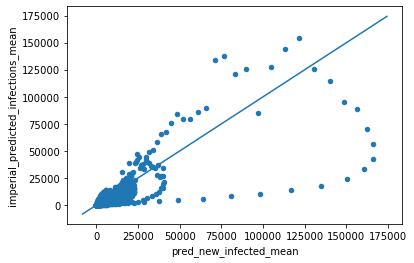

In [28]:
# The problem is that the new cases from the model_df is the actual reported new cases,
# because he doesn't project new cases after they've been realized. So I need to use his infection
# numbers to compare across. 
compare_df = imperial_df.merge(statemodel_df, on=['date', 'abbr'], how='left')
compare_df = compare_df.sort_values(by='date')
compare_df['ratio'] = compare_df['imperial_predicted_infections_mean']/compare_df['pred_new_infected_mean']

fig, ax = plt.subplots()
compare_df.plot(kind='scatter', x='pred_new_infected_mean', y='imperial_predicted_infections_mean', ax=ax)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x)

For a metric to compare them to a 45 degree line, maybe use Concordance correlation coefficient:
https://en.wikipedia.org/wiki/Concordance_correlation_coefficient. Values of ±1 denote perfect concordance and discordance; a value of zero denotes its complete absence. 

More info here: https://www.alexejgossmann.com/ccc/


    Looking at the above figures we see that the magnitude of the Pearson correlation coefficient ρ does not change under location and scale shift (though the sign may flip). The CCC on the other hand quantifies the deviation from the 45-degree line, which is due to location and scale shifts in these examples, rather well.

    This makes the CCC a better metric when we want to assess how well one measurement can reproduce another (i.e., how close the measurement pairs fall to the 45-degree line), while we would use ρ if what we want is quantifying to what extent the measurement pairs can be described by a linear equation (with any intercept and slope).

In [29]:
# Ok, that's actually pretty good, the mean ratio between the two is 1.06, which is pretty close to 1. 
# So there is a decently close correlation, but the high end values differ considerably.
# compare_df['ratio'].mean()
# 1.189955533881493

# This looks pretty good as well, concordance of 0.918 as of writing, 
# where 1 is the best, 0 is worst.
gu_series = compare_df['pred_new_infected_mean']
imperial_series = compare_df['imperial_predicted_infections_mean']

cov = gu_series.cov(imperial_series)
gu_mean = gu_series.mean()
gu_variance = gu_series.var()
imperial_mean = imperial_series.mean()
imperial_variance = imperial_series.var()
concordance_coef = (2*cov)/(gu_variance + imperial_variance + (gu_mean - imperial_mean)**2)
concordance_coef

0.7850399857205146

## Spain sanity checks

Based on the total reported count, `0.48%` of the nation has been infected as of 5/13/2020, while [serology](https://www.reuters.com/article/us-health-coronavirus-spain-study/spanish-antibody-study-points-to-5-of-population-affected-by-coronavirus-idUSKBN22P2RP) [says](https://www.vox.com/2020/5/16/21259492/covid-antibodies-spain-serology-study-coronavirus-immunity) `5%`. So there's a 10x undercount of official cases. But, interestingly, the model predicts around `6.7%` of Spain has been infected. So it's at least at the right order of magnitude, and it could be true depending on when the serology tests ended.

So even though you'd expect a model minimizing error on an [undercount](https://www.economist.com/graphic-detail/2020/04/16/tracking-covid-19-excess-deaths-across-countries) of the death rate to undercount total infections as well, this doesn't seem to be the case. Maybe undercounting deaths is a problem during major upswing, but not during steady state spread?

In [30]:
spainmax = world_df[
    (world_df['location'] == 'Spain') &
    (world_df['date'] < '2020-05-13')
]['total_cases'].max()
# https://en.wikipedia.org/wiki/Demographics_of_Spain
spainpop = 47007367
spainfraction = spainmax/spainpop
print('2020-05-13')
print('Total cases: ', spainmax)
print('Fraction reported infected: ', spainfraction)
# 6/10/2020
# Total cases:  241966.0
# Fraction reported infected:  0.00514740593745657

2020-05-13
Total cases:  228252.0
Fraction reported infected:  0.0048556644323431266


In [31]:
spainmodel_df = pd.read_csv('/Users/psthomas/Documents/projects/covid-vis/data/latest_global.csv')
spainmodelmax = spainmodel_df[
    (spainmodel_df['country'] == 'Spain') & 
    (spainmodel_df['date'] < '2020-05-13')
]['predicted_total_infected_mean'].max()
spainmodelfraction = spainmodelmax/spainpop
print('2020-05-13')
print('Total cases, modeled: ', spainmodelmax)
print('Fraction infected, model: ', spainmodelfraction)
# 6/10/2020
# Total cases, modeled:  3412609
# Fraction infected, model:  0.07259732288345357

2020-05-13
Total cases, modeled:  3196298
Fraction infected, model:  0.06799568246398485


## New York Sanity Checks

New York state has also done a preliminary [serology study](https://twitter.com/NYGovCuomo/status/1253352837255438338) completed on April 23rd that estimated a New York City infection rate of `21.2%` and a statewide rate of `13.9%`. The model predictions below of `20.9%` (city) and `12.5%` (state) are quite close.

**Update:** as of 7/26/2020, these are starting to be off by a bit. It's 24.8% city and 17.39% state at this point, so it's creeping upwards. There was a major model change recently, so that might be why. It seems to have substantially changed a number of values, and they don't agree with the case counts as much anymore. 

In [32]:
# New York City
#nycmax = countymodel_df[countymodel_df['location'] == 'New York City County, NY']['pred_total_infected_mean'].max()
nycmax = countymodel_df[
    (countymodel_df['location'] == 'New York City County, NY') &
    (countymodel_df['date'] < '2020-04-23')
]['pred_total_infected_mean'].max()
nycpop = countypop_df[countypop_df['county'] == 'New York City County']['population'].values[0]
print('2020-04-23')
print('Total infected: ', nycmax)
print('Total population: ', nycpop)
print('Fraction infected: ', nycmax/nycpop)
# 6/15/2020
# Total infected:  2085176
# Total population:  8746127
# Fraction infected:  0.2384113562494576

2020-04-23
Total infected:  2318953
Total population:  8746127
Fraction infected:  0.26514055878676357


In [33]:
# New York State
# https://www.reuters.com/article/us-health-coronavirus-usa-new-york-idUSKCN2252WN
nymax = statemodel_df[
    (statemodel_df['location'] == 'New York') & 
    (statemodel_df['date'] < '2020-04-23')
]['pred_total_infected_mean'].max()
nypop = statepop_df[statepop_df['state'] == 'New York']['population'].values[0]
print('2020-04-23')
print('Total infected: ', nymax)
print('Total population: ', nypop)
print('Fraction infected: ', nymax/nypop)
# 6/15/2020
# Total infected:  2957503.0
# Total population:  19453561
# Fraction infected:  0.15202887533033155

2020-04-23
Total infected:  3649085.0
Total population:  19453561
Fraction infected:  0.1875792817572063
